In [67]:
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import missingno as msno
import statsmodels as sm
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error as mse

# Read Data

### Source 
The data was downloaded from Kaggle(here). [(here)](https://www.kaggle.com/datasets/conorrot/irish-weather-hourly-data)
### Context
This dataset contains hourly weather data for a number of regions across Ireland.
### Content
This dataset contains data from 25 stations across 15 counties in Ireland. Hourly data is available for these weather stations from the start of their record keeping until the end of 2018. All data was sourced from the Irish meteorological service - Met Eireann.

### Load and Extract Temperature Data

In [4]:
#Load Data
Path = "Timeseries//hrly_Irish_weather.csv//hrly_Irish_weather.csv"
WeatherData = pd.read_csv(Path,low_memory=False)
WeatherData['date'] = pd.to_datetime(WeatherData['date'])
WeatherData.set_index('date', inplace=True)
WeatherData.to_pickle('IrishWeatherData')
#WeatherData = pd.read_pickle('IrishWeatherData')
Rows, Cols = WeatherData.shape
print(f'{Rows} rows and {Cols} columns')
WeatherData.head(5)

4660423 rows and 17 columns


,county,station,latitude,longitude,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir,sun,vis,clht,clamt
date,,,,,,,,,,,,,,,,,
2011-06-26 01:00:00,Galway,ATHENRY,53.289,-8.786,0.0,15.3,14.5,13.9,15.8,90,1016.0,8,190,NaN,NaN,NaN,NaN
2011-06-26 02:00:00,Galway,ATHENRY,53.289,-8.786,0.0,14.7,13.7,12.9,14.9,89,1015.8,7,190,NaN,NaN,NaN,NaN
2011-06-26 03:00:00,Galway,ATHENRY,53.289,-8.786,0.0,14.3,13.4,12.6,14.6,89,1015.5,6,190,NaN,NaN,NaN,NaN
2011-06-26 04:00:00,Galway,ATHENRY,53.289,-8.786,0.0,14.4,13.6,12.8,14.8,90,1015.3,7,180,NaN,NaN,NaN,NaN
2011-06-26 05:00:00,Galway,ATHENRY,53.289,-8.786,0.0,14.4,13.5,12.7,14.7,89,1015.1,6,190,NaN,NaN,NaN,NaN


### Dublin Airport Data Extration
The Dublin airport data is extrated and visualized

<AxesSubplot: >

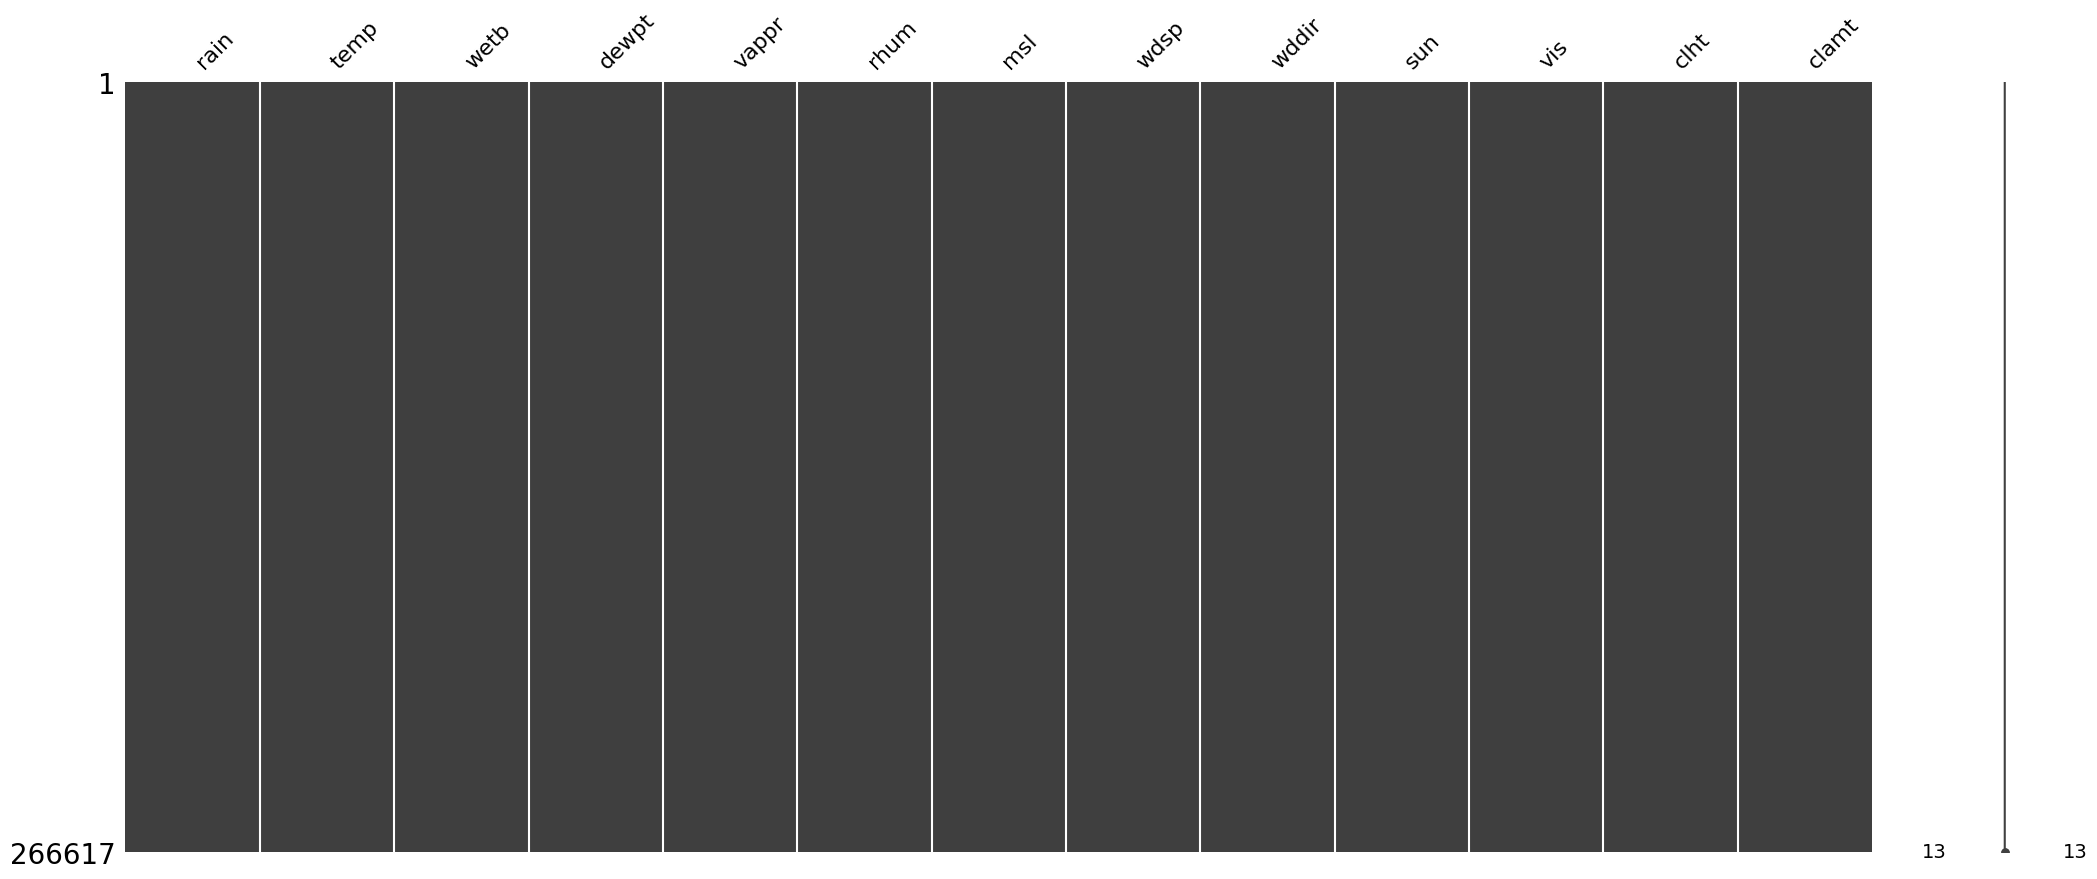

In [5]:
grouped = WeatherData.groupby('station')
IrishCountyWeatherData = {}
for name, group in grouped:
    df = group
    IrishCountyWeatherData.update({name: df})
df = IrishCountyWeatherData['DUBLIN AIRPORT']
df.drop(columns = ['county', 'station', 'latitude', 'longitude'], inplace = True)
msno.matrix(df)

In [6]:
df.replace(' ', np.nan, inplace=True)
for columns in df.columns:
    df[columns] = df[columns].astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 266617 entries, 1990-01-01 00:00:00 to 2020-06-01 00:00:00
Data columns (total 13 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   rain    266617 non-null  float64
 1   temp    266617 non-null  float64
 2   wetb    266617 non-null  float64
 3   dewpt   266617 non-null  float64
 4   vappr   266616 non-null  float64
 5   rhum    266616 non-null  float64
 6   msl     266617 non-null  float64
 7   wdsp    266617 non-null  float64
 8   wddir   266616 non-null  float64
 9   sun     266617 non-null  float64
 10  vis     266617 non-null  float64
 11  clht    266617 non-null  float64
 12  clamt   266617 non-null  float64
dtypes: float64(13)
memory usage: 28.5 MB


In [32]:
df['year'] = df.index.year
df['month'] = df.index.month
TempData = df[['temp','month','year']]
TempData = TempData.resample('D').mean()
TempData.head(5)

,temp,month,year
date,,,
1990-01-01,7.800000,1.0,1990.0
1990-01-02,7.845833,1.0,1990.0
1990-01-03,6.633333,1.0,1990.0
1990-01-04,8.412500,1.0,1990.0
1990-01-05,9.141667,1.0,1990.0


### Annual Seasonality of the Data

<AxesSubplot: xlabel='month', ylabel='temp'>

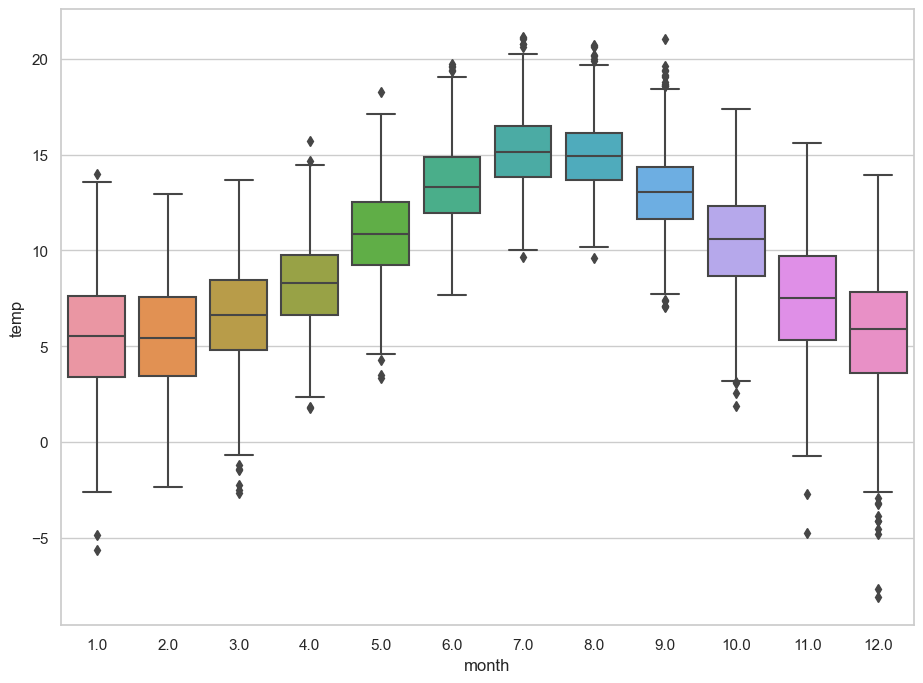

In [33]:
sns.set(rc={'figure.figsize':(11,8)},style="whitegrid")
sns.boxplot(x=TempData['month'],y=TempData['temp'],data=TempData)

### Extrating Data Properties
The trend, seasonality and the residual

In [66]:
ppt = TempData['temp'][TempData['year'] == 1991]
decomposed = sm.tsa.seasonal.seasonal_decompose(ppt, model ='additive')

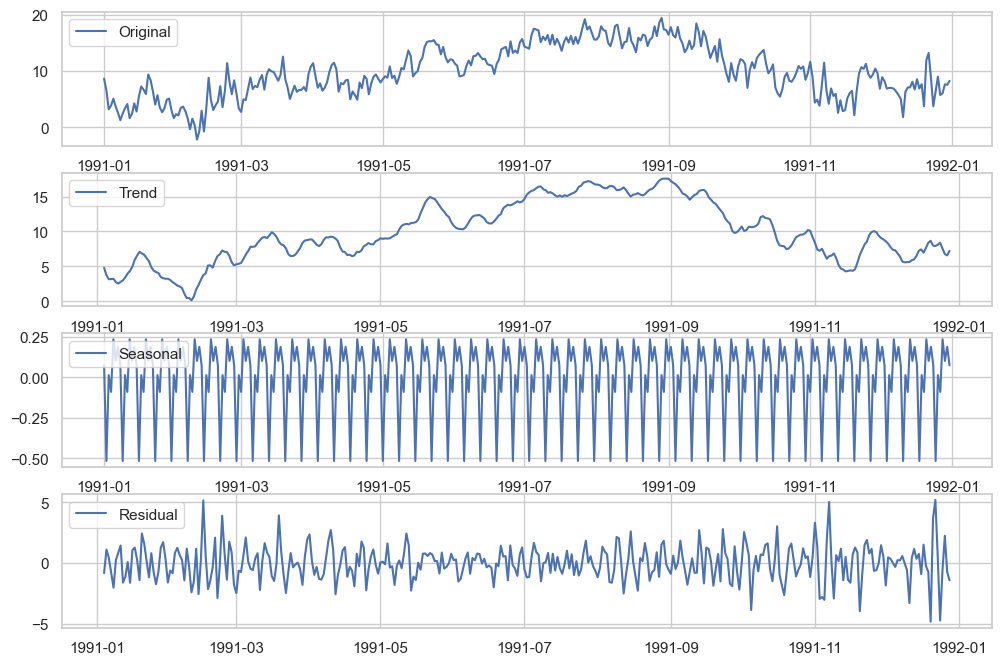

In [35]:
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(ppt, label='Original')
plt.legend(loc='upper left')
plt.subplot(412)
plt.plot(decomposed.trend, label='Trend')
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(decomposed.seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(decomposed.resid, label='Residual')
plt.legend(loc='upper left')
plt.show()

C:\Users\gogum\AppData\Local\Temp\ipykernel_35736\2426664570.py:2: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(211)


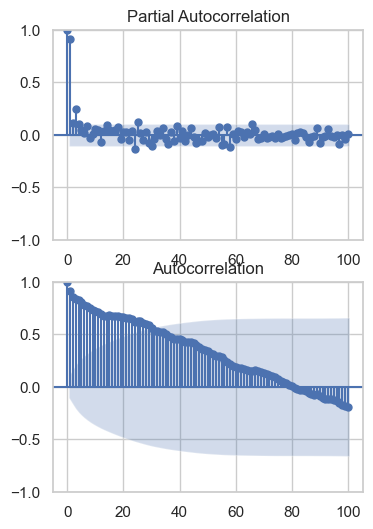

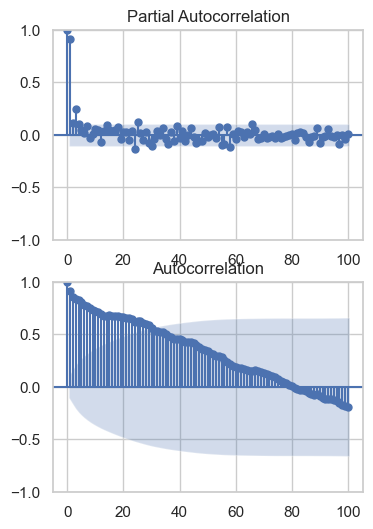

In [56]:
fig = plt.subplots(figsize=(4,6))
ax = plt.subplot(211)
az = plt.subplot(212)
sm.graphics.tsaplots.plot_pacf(ppt, lags = 100, ax=ax)
sm.graphics.tsaplots.plot_acf(ppt, lags = 100, ax=az)

## Model Development
### ARIMA Model Selection 
The Auto_ARIMA functiom evaluates the data to determine the best ARIMA variant that will be best to model the observation. 

In [57]:
arima_model = auto_arima(ppt, start_p = 1, d=1, start_q = 1, max_p = 5, max_q = 5, max_d=5, m = 12, start_P = 0, D=1, start_Q=0, max_P=5, max_D=5, max_Q=5,
                          seasonal = True, trace = True, error_action ='ignore', suppress_warnings = True, stepwise = True, n_fits=50) 

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=inf, Time=0.34 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1684.279, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1616.341, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.81 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1678.690, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1571.355, Time=0.32 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=1550.319, Time=0.59 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=1530.148, Time=1.03 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=1516.527, Time=4.98 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=1473.481, Time=22.51 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=4.16 sec
 ARIMA(1,1,0)(5,1,2)[12]             : AIC=1470.423, Time=53.23 sec
 ARIMA(1,1,0)(4,1,2)[12]             : AIC=1469.512, Time=8.91 sec
 ARIMA(1,1,0)(3,1,2)[12]             : AIC=1470.912, Time=5.87 sec
 ARIMA(1,1,0)(4,1,3)[12]        

In [58]:
print(arima_model.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  365
Model:             SARIMAX(2, 1, 1)x(4, 1, [1, 2], 12)   Log Likelihood                -709.616
Date:                                 Sat, 22 Jul 2023   AIC                           1439.233
Time:                                         23:49:16   BIC                           1477.869
Sample:                                     01-01-1991   HQIC                          1454.608
                                          - 12-31-1991                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2163      0.134      1.613      0.107      -0.046       0

From the result summary above the SARIMAX is the model that will represent theobservation better 
### Creating the SARIMAX Model

First, we split the data into a training and testing set

In [61]:
#Split data into train and test
ModelData = TempData['temp']
size = int(len(ModelData) * 0.66)
X_train, X_test = ModelData[0:size], ModelData[size:len(TempData)]

Using the training data, a SARIMAX model is built and fitted

In [62]:
model = sm.tsa.statespace.sarimax.SARIMAX(ModelData, order = (2, 1, 1), seasonal_order =(4, 1, [1, 2], 12))

In [63]:
result = model.fit() 
result.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                    temp   No. Observations:                11110
Model:             SARIMAX(2, 1, 1)x(4, 1, [1, 2], 12)   Log Likelihood              -22673.933
Date:                                 Sat, 22 Jul 2023   AIC                          45367.866
Time:                                         23:54:45   BIC                          45441.010
Sample:                                     01-01-1990   HQIC                         45392.497
                                          - 06-01-2020                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6640      0.011     61.919      0.000       0.643       0.685
ar.L2         -0.1243      0.009    -13.449      0.000      -0.142      -0.106
ma.L1         -0.8846      0.007   -126.941      0.000      -0.898      -0.871
ar.S.L12      -0.9644      0.044    -22.065      0.000      -1.050      -0.879
ar.S.L24      -0.0046      0.012     -0.365      0.715      -0.029       0.020
ar.S.L36       0.0199      0.013      1.563      0.118      -0.005       0.045
ar.S.L48       0.0179      0.010      1.865      0.062      -0.001       0.037
ma.S.L12      -0.0481      0.043     -1.117      0.264      -0.133       0.036
ma.S.L24      -0.9508      0.043    -22.163      0.000      -1.035      -0.867
sigma2         3.4613      0.045     76.537      0.000       3.373       3.550
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):               115.52
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               1.06   Skew:                             0.09
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Model Prediction 
Having developed the model, it is tested to evaluate the accuracy of the model

In [78]:
#Prediction
start_index = len(X_train)
end_index = len(TempData)-1
prediction = result.predict(start_index, end_index).rename('Predicted Temp') 
#Rename the column

### Model Validation

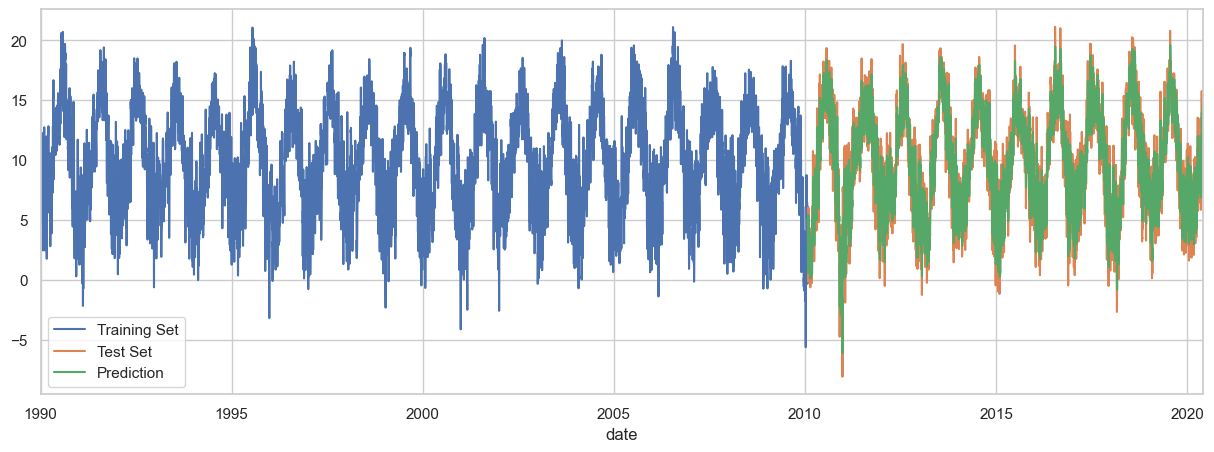

In [79]:
fig, ax = plt.subplots(figsize=(15,5))
X_train.plot(ax = ax, label = 'Training Set')
X_test.plot(ax = ax, label = 'Test Set')
prediction.plot(ax = ax, label = 'Prediction')
plt.legend()
plt.savefig('SARIMAX')
plt.show()

### Validation Metric

In [77]:
score =  np.sqrt(mse(X_test, prediction))
print(score)

1.8979219733123975
